In [93]:
import matplotlib.pyplot as plt
def plot_spectrogram(spectrogram, title=None):
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    if title:
        plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Crear dataset para AUTOVC a partir de listas de archivos

In [ ]:
import os
import pickle
import shutil

DATA_SOURCE = r''
DATASETS_ROOT = r''

dataset = 'dataset_7'
version = 'v1'
dataset_path = os.path.join(DATASETS_ROOT, dataset, version)
train_refs = pickle.load(open(os.path.join(dataset_path, 'refs_train.pickle'), "rb"))
test_refs = pickle.load(open(os.path.join(dataset_path, 'refs_test.pickle'), "rb"))

with open(f'{dataset_path}/params.txt', 'r') as f:
    first_line = f.readline().strip()
speakers = eval(first_line.replace('SPEAKERS: ', ''))

for spk in train_refs:
    spk_path = os.path.join(DATA_SOURCE, speakers[spk])
    for file in train_refs[spk]:
        src = os.path.join(spk_path, file)
        dst = os.path.join(f'data/{dataset}/train', speakers[spk], file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

for spk in test_refs:
    spk_path = os.path.join(DATA_SOURCE, speakers[spk])
    for file in test_refs[spk]:
        src = os.path.join(spk_path, file)
        dst = os.path.join(f'data/{dataset}/test', speakers[spk], file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

In [ ]:
import numpy as np
DATASETS_ROOT = r''

dataset = 'mi_voz'
version = 'v1'
dataset_path = os.path.join(DATASETS_ROOT, dataset, version)
data = pickle.load(open(os.path.join(dataset_path, 'data_test.pickle'), "rb"))[0]
refs = pickle.load(open(os.path.join(dataset_path, 'refs_test.pickle'), "rb"))[0]

for spec, refs in zip(data, refs):
    np.save(f'data/{dataset}/test/spmel_hifi/mi_voz/{refs.replace(".wav", ".npy")}', spec.T)
    

# Visualizaciones

In [54]:
import json
from matplotlib.ticker import FuncFormatter


def load_history(file_path, log_step=100):
    with open(file_path, 'r') as f:
        history = json.load(f)

    loss_id = history['G/loss_id']
    loss_id_post = history['G/loss_id_psnt']
    loss_cd = history['G/loss_cd']
    steps = [i * log_step for i in range(len(loss_id))]

    return steps, loss_id, loss_id_post, loss_cd

# Calcular una media por ventana del loss
def moving_average(data, window_size):
    return [sum(data[i:i + window_size]) / window_size for i in range(len(data) - window_size + 1)]

def plot_one_model_loss(file_path, model_name, initial_step=0, final_step=-1, window_size=100):
    steps, _, loss_id_post, _ = load_history(file_path)
    loss_id_moving_avg = moving_average(loss_id_post, window_size)
    steps_w = steps[window_size - 1:]

    plt.figure(figsize=(6, 4))
    plt.plot(steps_w[initial_step:final_step], loss_id_moving_avg[initial_step:final_step], label='G/loss_id_post')
    plt.title('Moving Average of G/loss_id_post')
    plt.xlabel('Steps')
    plt.ylabel('Loss')

    ax = plt.gca()
    formatter = FuncFormatter(lambda y, _: f'{y:.5f}')
    ax.yaxis.set_major_formatter(formatter)

    plt.legend()
    plt.grid()
    plt.show()

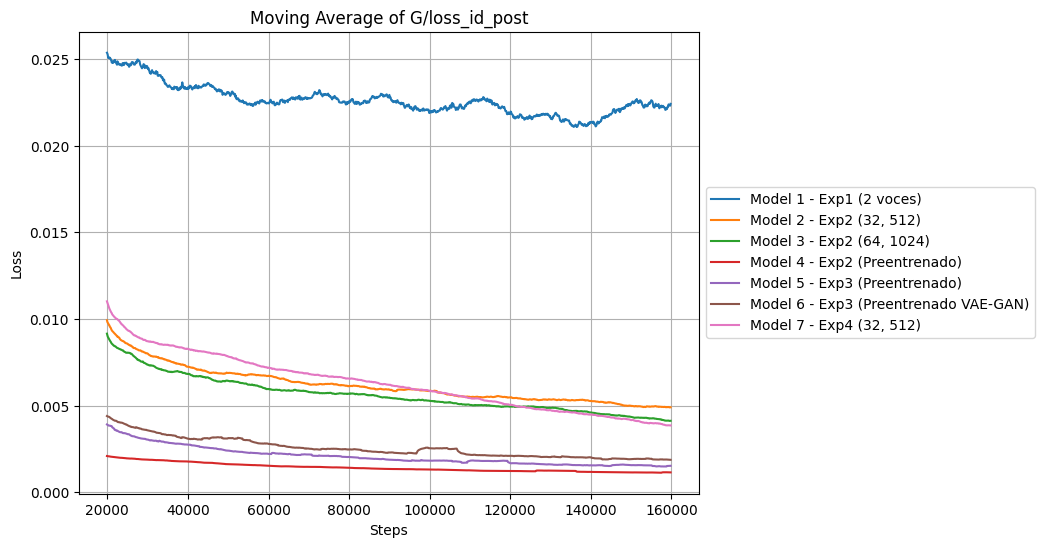

In [82]:
import os
import matplotlib.pyplot as plt

models = ['d4_autovc_1', 'd6_autovc_1', 'd6_autovc_2', 'd6_autovc_ft', 'd5_autovc_ft', 'd5_autovc_hifi_ft', 'd7_autovc_1']
model_names = ['Exp1 (2 voces)', 'Exp2 (32, 512)', 'Exp2 (64, 1024)', 'Exp2 (Preentrenado)', 'Exp3 (Preentrenado)', 'Exp3 (Preentrenado VAE-GAN)', 'Exp4 (32, 512)']

plt.figure(figsize=(8, 6))
for i, model in enumerate(models):
    file_path = os.path.join('checkpoints', model, 'history.json')
    steps, loss_id, loss_id_post, loss_cd = load_history(file_path)
    loss_id_moving_avg = moving_average(loss_id_post, 100)
    steps_w = steps[100 - 1:]
    plt.plot(steps_w[100:1500], loss_id_moving_avg[100:1500], label=f'Model {i + 1} - {model_names[i]}')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Moving Average of G/loss_id_post')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.grid()
plt.show()

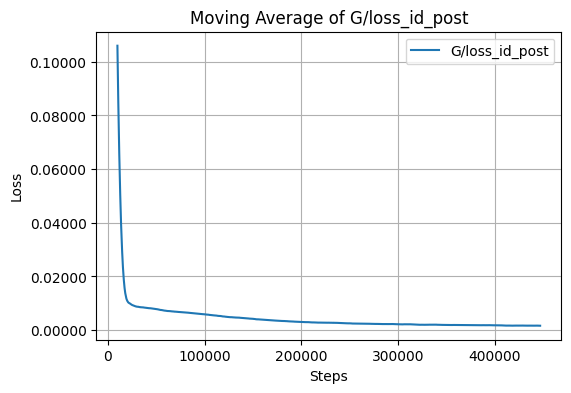

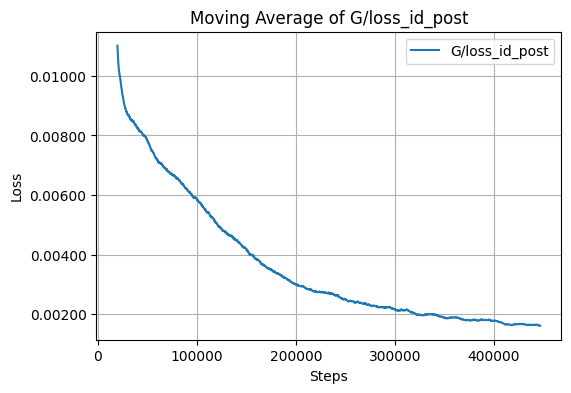

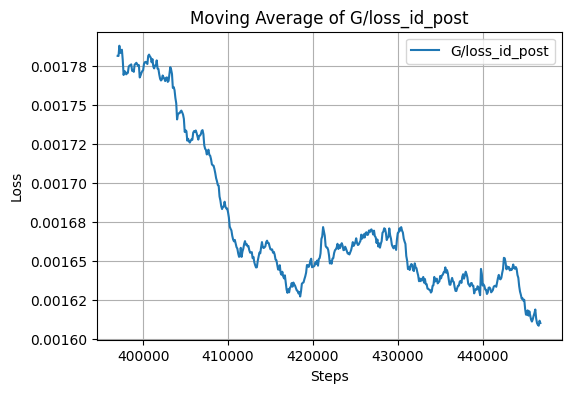

In [69]:
history_path = 'checkpoints/d7_autovc_1/history.json'


plot_one_model_loss(history_path, 'd4_autovc_1', initial_step=0)
plot_one_model_loss(history_path, 'd4_autovc_1', initial_step=100)
plot_one_model_loss(history_path, 'd4_autovc_1', initial_step=-500)

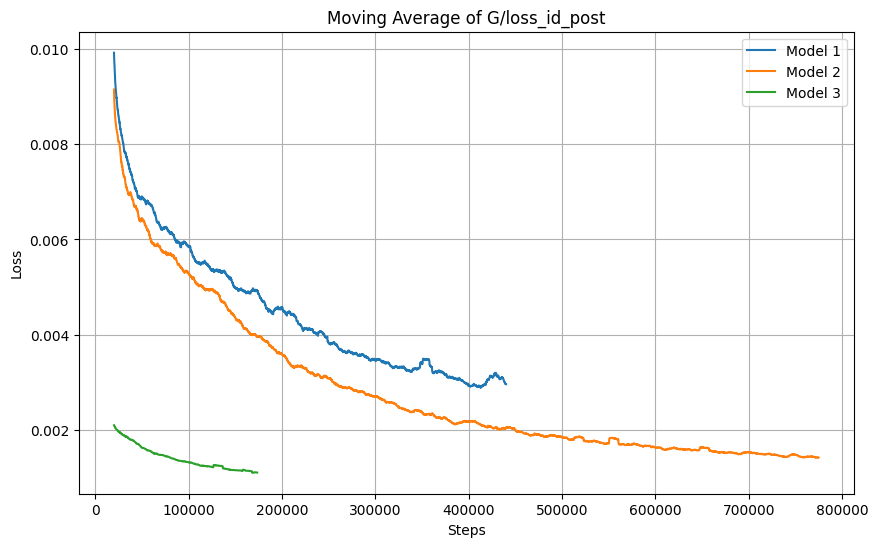

In [58]:
import os
import matplotlib.pyplot as plt

models = ['d6_autovc_1', 'd6_autovc_2', 'd6_autovc_ft']

plt.figure(figsize=(10, 6))
for i, model in enumerate(models):
    file_path = os.path.join('checkpoints', model, 'history.json')
    steps, loss_id, loss_id_post, loss_cd = load_history(file_path)
    loss_id_moving_avg = moving_average(loss_id_post, 100)
    steps_w = steps[100 - 1:]
    plt.plot(steps_w[100:], loss_id_moving_avg[100:], label=f'Model {i + 1}')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Moving Average of G/loss_id_post')
plt.legend()
plt.grid()
plt.show()

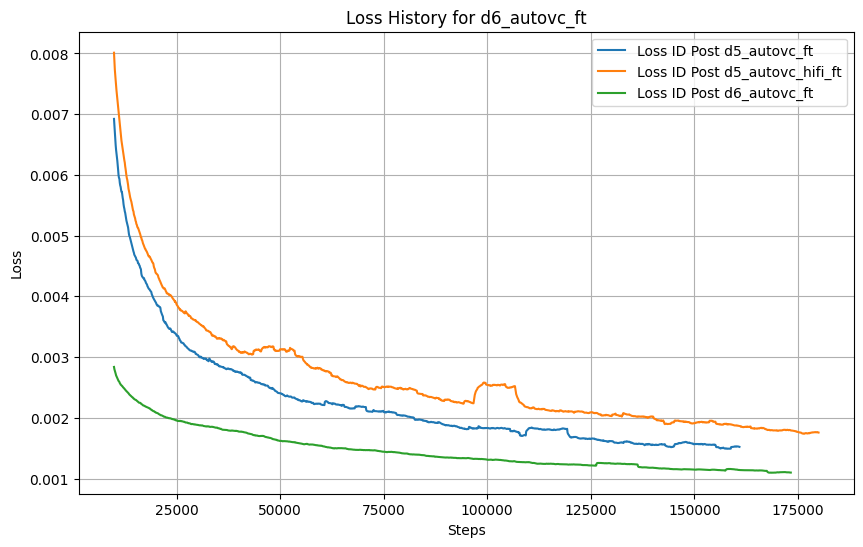

In [68]:
models = ['d5_autovc_ft', 'd5_autovc_hifi_ft', 'd6_autovc_ft']

plt.figure(figsize=(10, 6))
for model in models:
    file_path = os.path.join('checkpoints', model, 'history.json')
    steps, loss_id, loss_id_post, loss_cd = load_history(file_path)
    loss_id_moving_avg = moving_average(loss_id_post, 100)
    steps_w = steps[100 - 1:]
    plt.plot(steps_w, loss_id_moving_avg, label=f'Loss ID Post {model}')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title(f'Loss History for {model}')
plt.legend()
plt.grid()
plt.show()

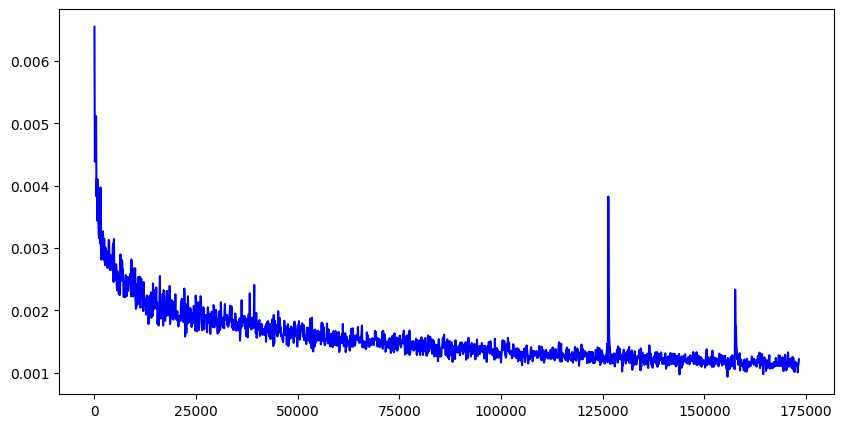

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(steps, history['G/loss_id'], label='G/loss_id', color='blue')
plt.show()

# Conversión

In [ ]:
import os
import pickle
import torch
import numpy as np
from math import ceil
from model_vc import Generator
import json


def pad_seq(x, base=32):
    len_out = int(base * ceil(float(x.shape[0])/base))
    len_pad = len_out - x.shape[0]
    assert len_pad >= 0
    return np.pad(x, ((0,len_pad),(0,0)), 'constant'), len_pad

device = 'cuda'

MODEL_NAME = 'd7_autovc_1'
STEP = 240000
DATASET = 'dataset_7'

chk_path = os.path.join('checkpoints', MODEL_NAME, 'G-{}.pth'.format(STEP))
if not os.path.exists(chk_path):
    raise FileNotFoundError(f"Checkpoint {chk_path} does not exist.")

config = json.load(open(os.path.join('checkpoints', MODEL_NAME, 'config.json'), 'r'))
dim_neck = config['dim_neck']
dim_emb = config['dim_emb']
dim_pre = config['dim_pre']
freq = config['freq']

G = Generator(dim_neck,dim_emb,dim_pre,freq).eval().to(device)

g_checkpoint = torch.load(chk_path, map_location=device)
G.load_state_dict(g_checkpoint)

test_data = pickle.load(open(f'data/{DATASET}/test/spmel/test.pkl', "rb"))

spkr_names = [spkr[0] for spkr in test_data]
spkr_embs = [spkr[1] for spkr in test_data]


selected_spkrs = ['f2196', 'f7794', 'm196', 'm3436']

results = {
    spkr_src: {spkr_trg: [] for spkr_trg in selected_spkrs}
    for spkr_src in selected_spkrs
}

for i, sp in enumerate(selected_spkrs):
    spkr_src_idx = spkr_names.index(sp)
    if sp not in spkr_names:
        raise ValueError(f"Speaker {sp} not found in the dataset.")
    spkr_paths = test_data[spkr_src_idx][2:]

    for path in spkr_paths:
        x_org = np.load(os.path.join('data', DATASET, 'test','spmel', path))     
        x_org, len_pad = pad_seq(x_org)

        uttr_org = torch.from_numpy(x_org[np.newaxis, :, :]).to(device)        
        emb_org = torch.from_numpy(spkr_embs[spkr_src_idx][np.newaxis, :]).to(device)
        
        for j, sp_trg in enumerate(selected_spkrs):
            spkr_trg_idx = spkr_names.index(sp_trg)
            emb_trg = torch.from_numpy(spkr_embs[spkr_trg_idx][np.newaxis, :]).to(device)
            
            with torch.no_grad():
                _, x_identic_psnt, _ = G(uttr_org, emb_org, emb_trg)
                
            if len_pad == 0:
                uttr_trg = x_identic_psnt[0, 0, :, :].cpu().numpy()
            else:
                uttr_trg = x_identic_psnt[0, 0, :-len_pad, :].cpu().numpy()
            
            results[sp][sp_trg].append((os.path.split(path)[1].split('.')[0], uttr_trg))

save_dir = f'results/{MODEL_NAME}'  
if not os.path.exists(save_dir):
    os.makedirs(save_dir)  
with open(f'{save_dir}/G-{STEP}_results.pkl', 'wb') as handle:
    pickle.dump(results, handle)  

# Síntesis

In [143]:
def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)


def spectral_normalize_torch(magnitudes):
    output = dynamic_range_compression_torch(magnitudes)
    return output

min_level_db = -100
ref_level_db = 20

def denormalize(S):
    return (np.clip(S, 0, 1) * -min_level_db) + min_level_db

def db_to_amp(x):
    return np.power(10.0, x * 0.05)

In [ ]:
from synthesis import build_hifi
import IPython.display as ipd
import pickle
import torch
import os
import soundfile as sf
import numpy as np

hifi = build_hifi('g_03280000')
hifi.eval()
hifi.to('cuda')

MODEL_NAME = 'd7_autovc_1'
STEP = 240000
CUSTOM = False

data = pickle.load(open(f'results/{MODEL_NAME}/G-{STEP}_results.pkl', 'rb'))

for spkr_src in data:
    print(f'Processing speaker: {spkr_src}')
    for spkr_trg in data[spkr_src]:
        print(f'  Target speaker: {spkr_trg}')
        for utt_id, uttr_trg in data[spkr_src][spkr_trg]:
            print(f'    Utterance ID: {utt_id}', end='\r')
            if uttr_trg.shape[0] != 80:
                uttr_trg = uttr_trg.T
            if CUSTOM:
                with torch.no_grad():
                    uttr_trg = denormalize(uttr_trg)
                    uttr_trg = db_to_amp(uttr_trg)
                    uttr_trg = torch.FloatTensor(uttr_trg).to('cuda')
                    mel = spectral_normalize_torch(uttr_trg)

                    audio = hifi(mel).squeeze()
                    MAX_WAV_VALUE = 32768.0
                    audio = audio * MAX_WAV_VALUE
                    audio = audio.cpu().detach().numpy().astype(np.int16)
                
            else:

                mel = torch.from_numpy(uttr_trg).unsqueeze(0).to(torch.float32).to('cuda')
                with torch.no_grad():
                    audio = hifi(mel).squeeze().cpu().numpy()
            audio_path = os.path.join('results', MODEL_NAME,f'G-{STEP}_' 'HIFI_converted_audios', spkr_src, spkr_trg, f'{utt_id}.wav')

            os.makedirs(os.path.dirname(audio_path), exist_ok=True)
            sf.write(audio_path, audio, 22050 if CUSTOM else 16000)


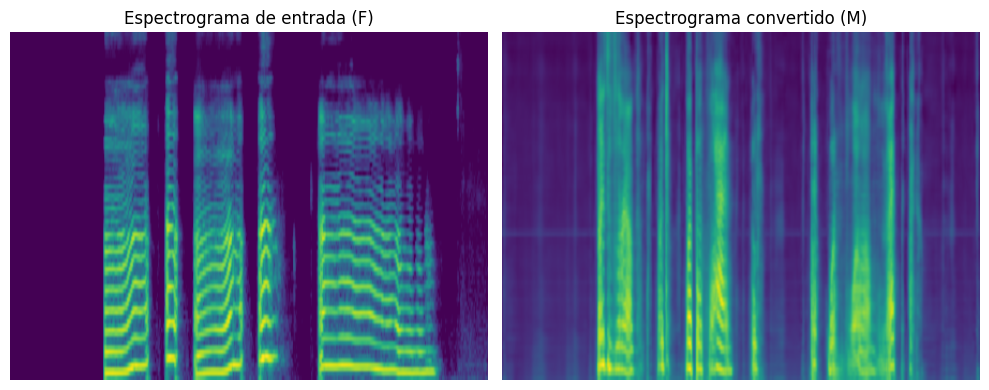

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(real_spec.T, aspect='auto', origin='lower', cmap='viridis')
plt.title('Espectrograma de entrada (F)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(spec.T, aspect='auto', origin='lower', cmap='viridis')
plt.title('Espectrograma convertido (M)')
plt.axis('off')
plt.tight_layout()
plt.show()

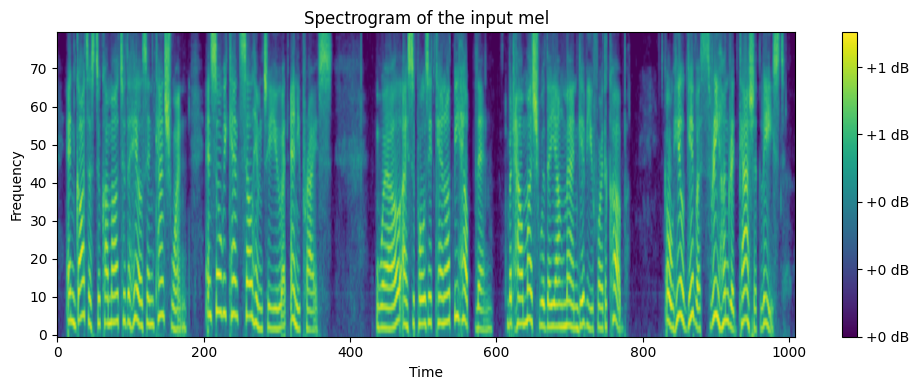

In [98]:
plot_spectrogram(real_spec.T, title='Spectrogram of the input mel')

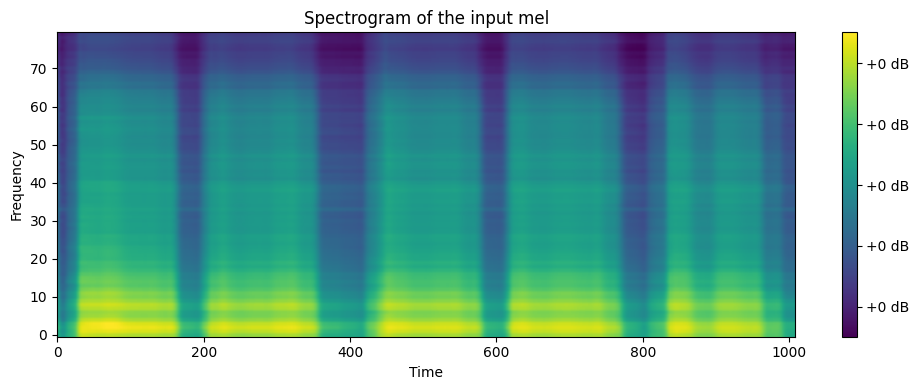

In [99]:
plot_spectrogram(spec.T, title='Spectrogram of the input mel')

# Otros

## Análisis de los embeddings de speaker

In [9]:
import pickle

DATASET = 'dataset_5'
test_metadata = pickle.load(open(f'./data/{DATASET}/test/spmel/test.pkl', 'rb'))
train_metadata = pickle.load(open(f'./data/{DATASET}/train/spmel/train.pkl', 'rb'))

In [2]:
f1_train_emb = train_metadata[0][1]
f1_test_emb = test_metadata[0][1]

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


for spk in range(len(train_metadata)):
    emb_train = train_metadata[spk][1]
    emb_test = test_metadata[spk][1]

    if emb_train.ndim > 1:
        emb_train = emb_train.mean(axis=0)
    if emb_test.ndim > 1:
        emb_test = emb_test.mean(axis=0)
    sim = cosine_similarity([emb_train], [emb_test])[0,0]
    print(f"Speaker {spk}: cosine similarity train vs test = {sim:.4f}")

Speaker 0: cosine similarity train vs test = 0.6642
Speaker 1: cosine similarity train vs test = 0.6909
Speaker 2: cosine similarity train vs test = 0.5407
Speaker 3: cosine similarity train vs test = 0.7770
Speaker 4: cosine similarity train vs test = 0.5696
Speaker 5: cosine similarity train vs test = 0.7913
Speaker 6: cosine similarity train vs test = 0.4269
Speaker 7: cosine similarity train vs test = 0.4182
Speaker 8: cosine similarity train vs test = 0.5663
Speaker 9: cosine similarity train vs test = 0.6857
Speaker 10: cosine similarity train vs test = 0.7765
Speaker 11: cosine similarity train vs test = 0.4111
Speaker 12: cosine similarity train vs test = 0.5055
Speaker 13: cosine similarity train vs test = 0.4535
Speaker 14: cosine similarity train vs test = 0.5849
Speaker 15: cosine similarity train vs test = 0.7570
Speaker 16: cosine similarity train vs test = 0.6777
Speaker 17: cosine similarity train vs test = 0.8043
Speaker 18: cosine similarity train vs test = 0.7573
Spe

## Crear dataset de n hablantes con más duración de audio, mitad M mitad F

In [ ]:
import os
import shutil

LIBRISPEECH_ROOT = r'LibriSpeech'

speakers = open(os.path.join(LIBRISPEECH_ROOT, 'SPEAKERS.txt'), 'r').readlines()
speakers = [s.strip() for s in speakers][12:]
selected_speakers = [s for s in speakers if 'train-clean-100' in s]
selected_speakers = [s.split('|') for s in selected_speakers]
selected_speakers = [[s[0].strip(), s[1].strip(), float(s[3].strip())] for s in selected_speakers]
selected_speakers_sorted = sorted(selected_speakers, key=lambda x: x[2], reverse=True)

number_speakers = 20
DATA_TARGET = rf'data_source\read_voices_{number_speakers}'

selected_m = 0
selected_f = 0

selected_spkrs_id = []
for spk in selected_speakers_sorted:
    if selected_m < number_speakers/2 and spk[1] == 'M':
        selected_m += 1
        selected_spkrs_id.append((spk[0], 'm'))

    elif selected_f < number_speakers/2 and spk[1] == 'F':
        selected_f += 1
        selected_spkrs_id.append((spk[0], 'f'))

print(f'Selected speakers: {selected_spkrs_id}')

for spk, g in selected_spkrs_id:
    data_path = os.path.join(LIBRISPEECH_ROOT, 'train-clean-100', spk)
    target_path = os.path.join(DATA_TARGET, g+spk)

    if not os.path.exists(target_path):
        os.makedirs(target_path)
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith('.flac'):
                src = os.path.join(root, file)
                dst = os.path.join(target_path, file)
                shutil.copy(src, dst)
                

Selected speakers: [('3436', 'm'), ('196', 'm'), ('2196', 'f'), ('7447', 'm'), ('460', 'm'), ('7794', 'f'), ('8051', 'f'), ('8468', 'f'), ('211', 'f'), ('831', 'm'), ('5393', 'f'), ('6454', 'm'), ('7190', 'm'), ('8419', 'm'), ('226', 'f'), ('426', 'f'), ('2007', 'f'), ('2989', 'f'), ('4014', 'm'), ('5390', 'm')]


## Cargar espectrogramas Mel con preprocesamiento de VAE-GAN

In [ ]:
import os
import pickle
import numpy as np

DATASETS_ROOT = r'datasets'

dataset = 'dataset_5'
version = 'v1'
dataset_path = os.path.join(DATASETS_ROOT, dataset, version)
train_data = pickle.load(open(os.path.join(dataset_path, 'data_train.pickle'), "rb"))
test_data = pickle.load(open(os.path.join(dataset_path, 'data_test.pickle'), "rb"))
train_refs = pickle.load(open(os.path.join(dataset_path, 'refs_train.pickle'), "rb"))
test_refs = pickle.load(open(os.path.join(dataset_path, 'refs_test.pickle'), "rb"))

with open(f'{dataset_path}/params.txt', 'r') as f:
    first_line = f.readline().strip()
speakers = eval(first_line.replace('SPEAKERS: ', ''))

target_dir = os.path.join('data', dataset, 'train', 'spmel_hifi')
os.makedirs(target_dir, exist_ok=True)

for spk in train_data:
    mels = train_data[spk]
    names = train_refs[spk]
    spk_name = speakers[spk]
    os.makedirs(os.path.join(target_dir, spk_name), exist_ok=True)
    for i, mel in enumerate(mels):
        mel = mel.T
        filename = names[i].replace('.wav', '.npy')  # Ensure the filename ends with .npy
        print(f'Saving mel for {speakers[spk]}: {filename} {mel.shape}')
        np.save(os.path.join(target_dir,spk_name, filename), mel)

# Save the test data in a similar way
target_dir_test = os.path.join('data', dataset, 'test', 'spmel_hifi')
os.makedirs(target_dir_test, exist_ok=True)

for spk in test_data:
    mels = test_data[spk]
    names = test_refs[spk]
    spk_name = speakers[spk]
    os.makedirs(os.path.join(target_dir_test, spk_name), exist_ok=True)
    for i, mel in enumerate(mels):
        mel = mel.T
        filename = names[i].replace('.wav', '.npy')  # Ensure the filename ends with .npy
        print(f'Saving mel for {speakers[spk]}: {filename} {mel.shape}')
        np.save(os.path.join(target_dir_test, spk_name, filename), mel)

Saving mel for m1: m1_scales_belt_o.npy (639, 80)
Saving mel for m1: m1_long_inhaled_o.npy (405, 80)
Saving mel for m1: m1_scales_c_slow_forte_a.npy (893, 80)
Saving mel for m1: m1_long_straight_u.npy (811, 80)
Saving mel for m1: m1_scales_belt_e.npy (627, 80)
Saving mel for m1: m1_scales_straight_e.npy (1557, 80)
Saving mel for m1: m1_arpeggios_f_fast_forte_a.npy (177, 80)
Saving mel for m1: m1_row_vibrato.npy (1318, 80)
Saving mel for m1: m1_arpeggios_vocal_fry_e.npy (1036, 80)
Saving mel for m1: m1_scales_lip_trill_o.npy (719, 80)
Saving mel for m1: m1_scales_f_slow_forte_a.npy (1153, 80)
Saving mel for m1: m1_arpeggios_c_slow_piano_u.npy (955, 80)
Saving mel for m1: m1_long_forte_u.npy (843, 80)
Saving mel for m1: m1_long_forte_i.npy (879, 80)
Saving mel for m1: m1_scales_c_fast_forte_e.npy (342, 80)
Saving mel for m1: m1_arpeggios_c_fast_piano_a.npy (171, 80)
Saving mel for m1: m1_scales_breathy_e.npy (1154, 80)
Saving mel for m1: m1_arpeggios_c_fast_piano_u.npy (179, 80)
Saving m